In [2]:
# Useful resources
# https://medium.com/analytics-vidhya/testing-multiple-machine-learning-models-at-once-without-getting-a-headache-5aefb0e7df03
# Potentially look into ensemble models

In [3]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess

seed = 38 # Seed for train/val split

In [4]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [5]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]

    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))

    # group by datetime, tag, tower and antenna, compute mean power, pivot to antennas
    sim_dat_filt = (
        sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
        .mean()
        .reset_index()
        .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values='Power')
        .reset_index()
        .rename(columns={1: 'ant1', 2: 'ant2', 3: 'ant3', 4: 'ant4'})
        .fillna(value=0) # Need to check the impact of this
    )
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)

    return sim_dat_filt

In [6]:
# Get simulation data
sim_data_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\RTdat_sim_train_20230212.xlsx'
sim_data = pd.read_excel(sim_data_path)
sim_data['DateAndTime'] = pd.to_datetime(sim_data['DateAndTime'])

# Get tower locations
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'
tower_locs = pd.read_excel(radio_tower_xy_path)


In [7]:
# Initial pass over the data using lazy predict to identify possible options
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

In [8]:
# Drilling into top performing models for paramater optimisation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create a list of test dictionaries
KNeighborsRegressor_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}]
AdaBoostRegressor_params = [{"n_estimators":25}, {"n_estimators":50}, {"n_estimators":75}]

# Create classes for the models
modelclasses = [
    ["K neighbours regressor", KNeighborsRegressor, KNeighborsRegressor_params],
    ["Ada boost regressor", AdaBoostRegressor, AdaBoostRegressor_params]
]

In [9]:
# Pre-processing parameters to test
# Variable parameters
data_type = ['Simulation'] # Simulation or Live BTF, or could do both
frequencies = ['1min', '5min']
cv = [] #To be updated

# Fixed parameters
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1', 'ant2', 'ant3', 'ant4']
responses = ['xOffset', 'yOffset']
scoring = 'neg_mean_absolute_error'

trained_models = []
for dimension in dimensions:
    for freq in frequencies:
        sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
        X_train = sim_data_preproc[predictors]
        y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

        # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

        for modelname, Model, params_list in modelclasses:
            for params in params_list:
                model = Model(**params)
                scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
                score = np.mean(scores)
                model.fit(X_train, y_train)
                trained_models.append((dimension, modelname, model, params, freq, score))

In [10]:
best_models = []
for dimension in dimensions:
    filtered = [x for x in trained_models if x[0] == dimension]
    filtered.sort(key=lambda x:x[-1], reverse=True)
    best_model = filtered[0]
    best_models.append(best_model)
    print(f"\nThe best performing model for {dimension} was {best_model}\n\nAll model results as follows:")

    for dimension, modelname, model, params, freq, score in filtered:
        print(dimension, modelname, params, freq, score)        


The best performing model for xOffset was ('xOffset', 'K neighbours regressor', KNeighborsRegressor(n_neighbors=7), {'n_neighbors': 7}, '5min', -330.47414811013624)

All model results as follows:
xOffset K neighbours regressor {'n_neighbors': 7} 5min -330.47414811013624
xOffset K neighbours regressor {'n_neighbors': 5} 5min -336.9463595525065
xOffset Ada boost regressor {'n_estimators': 25} 1min -356.6096199557985
xOffset K neighbours regressor {'n_neighbors': 3} 5min -358.0420858763479
xOffset K neighbours regressor {'n_neighbors': 7} 1min -358.6632137873644
xOffset Ada boost regressor {'n_estimators': 75} 1min -359.9663025281861
xOffset Ada boost regressor {'n_estimators': 75} 5min -362.29366443171347
xOffset Ada boost regressor {'n_estimators': 50} 5min -365.1432784616815
xOffset K neighbours regressor {'n_neighbors': 5} 1min -367.4301979368288
xOffset Ada boost regressor {'n_estimators': 25} 5min -374.31787783400256
xOffset Ada boost regressor {'n_estimators': 50} 1min -378.027527

In [11]:
# Pre-process test data !!!!!!!!!!!change code to reflect test data
sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs) #### Change this to Test data

# Isolate predictor variables from test data
X_test = sim_data_preproc[predictors]

for dimension in dimensions:
    best_model = [x for x in best_models if x[0] == dimension]
    model = best_model[0][2]
    freq = best_model[0][4]

    # Isolate response variable from test data
    y_test = sim_data_preproc[dimension]

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Save predictions to a new column in the test data pandas dataframe
    pred_column_name = f"{dimension}_pred"
    sim_data_preproc[pred_column_name] = y_pred

    # # Save frequency of predictions to the pandas dataframe !!!!!!!!!!Consider deleting, I don't think it's needed
    # freq_column_name = f"{dimension}_freq"
    # sim_data_preproc[freq_column_name] = freq

In [12]:
sim_data_preproc

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred
0,2021-03-19 07:54:00,RT01,70,146.255492,-21.919407,0.0,0.0,0.0,84.0,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,-497.401942,-32.265108
1,2021-03-19 07:54:00,RT04,70,146.255492,-21.919407,105.0,80.0,0.0,0.0,423106.337491,7.575907e+06,55,K,160.219630,233.088540,116.429167,294.862593
2,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,70.0,0.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-282.582580,495.944163,-110.628503,287.144200
3,2021-03-19 07:55:00,RT05,70,146.255492,-21.919407,0.0,0.0,85.5,0.0,423106.337491,7.575907e+06,55,K,161.161349,-265.160411,-55.772179,-383.965873
4,2021-03-19 07:55:00,RT07,70,146.255492,-21.919407,0.0,67.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-680.791419,-224.583856,-23.134596,-192.963957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,2021-04-23 15:09:00,RT03,70,146.252698,-21.920308,66.0,0.0,0.0,0.0,422818.243652,7.575806e+06,55,K,-570.676419,394.808378,-201.901523,16.041927
1061,2021-04-23 15:11:00,RT01,70,146.251197,-21.920565,0.0,76.0,0.0,85.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,-430.966631,-45.218327
1062,2021-04-23 15:11:00,RT05,70,146.251197,-21.920565,14.0,0.0,0.0,0.0,422663.351956,7.575777e+06,55,K,-281.824186,-395.499647,-480.588228,-1245.816705
1063,2021-04-23 15:12:00,RT01,70,146.251197,-21.920565,0.0,74.0,0.0,29.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,112.729757,-101.273543


In [13]:
#Convert locations predictions back to easting northings

def postprocess_data(prediction_data, tower_locs):
    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Change predicted x/y offset values to their respective easting/northing considering the location of the tower
    prediction_data['easting_pred'] = prediction_data['xOffset_pred'] + prediction_data['TowerID'].map(point_x).fillna(0)
    prediction_data['northing_pred'] = prediction_data['yOffset_pred'] + prediction_data['TowerID'].map(point_y).fillna(0)
    
    return prediction_data

In [39]:
test_predictions = postprocess_data(sim_data_preproc, tower_locs)



##########Consider removing zone_num and zone_letter from output

In [15]:
test_predictions

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred,easting_pred,northing_pred
0,2021-03-19 07:54:00,RT01,70,146.255492,-21.919407,0.0,0.0,0.0,84.0,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,-497.401942,-32.265108,422841.329242,7.575886e+06
1,2021-03-19 07:54:00,RT04,70,146.255492,-21.919407,105.0,80.0,0.0,0.0,423106.337491,7.575907e+06,55,K,160.219630,233.088540,116.429167,294.862593,423062.547028,7.575969e+06
2,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,70.0,0.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-282.582580,495.944163,-110.628503,287.144200,423278.291568,7.575698e+06
3,2021-03-19 07:55:00,RT05,70,146.255492,-21.919407,0.0,0.0,85.5,0.0,423106.337491,7.575907e+06,55,K,161.161349,-265.160411,-55.772179,-383.965873,422889.403963,7.575788e+06
4,2021-03-19 07:55:00,RT07,70,146.255492,-21.919407,0.0,67.0,0.0,0.0,423106.337491,7.575907e+06,55,K,-680.791419,-224.583856,-23.134596,-192.963957,423763.994314,7.575939e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,2021-04-23 15:09:00,RT03,70,146.252698,-21.920308,66.0,0.0,0.0,0.0,422818.243652,7.575806e+06,55,K,-570.676419,394.808378,-201.901523,16.041927,423187.018548,7.575427e+06
1061,2021-04-23 15:11:00,RT01,70,146.251197,-21.920565,0.0,76.0,0.0,85.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,-430.966631,-45.218327,422907.764553,7.575873e+06
1062,2021-04-23 15:11:00,RT05,70,146.251197,-21.920565,14.0,0.0,0.0,0.0,422663.351956,7.575777e+06,55,K,-281.824186,-395.499647,-480.588228,-1245.816705,422464.587914,7.574926e+06
1063,2021-04-23 15:12:00,RT01,70,146.251197,-21.920565,0.0,74.0,0.0,29.0,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,112.729757,-101.273543,423451.460941,7.575817e+06


In [40]:
# Average easting and northings across time interval
UTM_predictions = (test_predictions.groupby(['DateTime', 'TagID'], as_index=False)
    .agg({'easting':'first',
        'northing':'first',
        'easting_pred':'mean',
        'northing_pred':'mean'
        })
)

UTM_predictions

#potentially add a spline?, or use a spline in the place of the average? Lowess smoothing function looks good

Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred
0,2021-03-19 07:54:00,70,423106.337491,7.575907e+06,422951.938135,7.575928e+06
1,2021-03-19 07:55:00,70,423106.337491,7.575907e+06,423310.563281,7.575808e+06
2,2021-03-19 07:56:00,70,423106.337491,7.575907e+06,423277.589395,7.575824e+06
3,2021-03-19 08:00:00,70,423135.777968,7.575992e+06,422850.830272,7.575978e+06
4,2021-03-19 08:01:00,70,423135.777968,7.575992e+06,423358.653614,7.575871e+06
...,...,...,...,...,...,...
442,2021-04-23 15:08:00,70,422818.243652,7.575806e+06,422925.081236,7.575774e+06
443,2021-04-23 15:09:00,70,422818.243652,7.575806e+06,423019.294538,7.575659e+06
444,2021-04-23 15:11:00,70,422663.351956,7.575777e+06,422686.176234,7.575400e+06
445,2021-04-23 15:12:00,70,422663.351956,7.575777e+06,423451.460941,7.575817e+06


In [88]:
######## update this code to apply for both the x and y offset
max_gap_4_smoothing = 20 # in minutes

UTM_predictions = UTM_predictions.sort_values(by='DateTime')
tag_ids = UTM_predictions['TagID'].unique()

# Loop through each unique value of 'TagID'
for tag_id in tag_ids:
    # Filter the dataframe to only include rows with the current 'TagID'
    UTM_predictions_filtered = UTM_predictions[UTM_predictions['TagID'] == tag_id]
    
    # Calculate the difference in minutes between each DateTime
    UTM_predictions_filtered['diff'] = UTM_predictions_filtered['DateTime'].diff().dt.total_seconds() / 60
    
    # Find the indices where the difference is greater than 10 minutes
    split_indices = UTM_predictions_filtered[UTM_predictions_filtered['diff'] > max_gap_4_smoothing].index
    
    # Split the filtered dataframe into subsets based on the split_indices
    split_data = np.split(UTM_predictions_filtered, split_indices)
    
    # Loop through each subset of the dataframe
    for subset in split_data:
        index_list = subset.index
        if len(subset) < 2:
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = UTM_predictions.loc[index_list, 'easting_pred']
        else:
            smoothed_values = lowess(subset['easting_pred'], subset['DateTime'], is_sorted=False, return_sorted=False)
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = smoothed_values

# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

UTM_predictions

Easting MAE = 211.92929137603605


Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred,easting_pred_smooth
0,2021-03-19 07:54:00,70,423106.337491,7.575907e+06,422951.938135,7.575928e+06,423160.505083
1,2021-03-19 07:55:00,70,423106.337491,7.575907e+06,423310.563281,7.575808e+06,423167.449505
2,2021-03-19 07:56:00,70,423106.337491,7.575907e+06,423277.589395,7.575824e+06,423174.399896
3,2021-03-19 08:00:00,70,423135.777968,7.575992e+06,422850.830272,7.575978e+06,423202.230768
4,2021-03-19 08:01:00,70,423135.777968,7.575992e+06,423358.653614,7.575871e+06,423209.183673
...,...,...,...,...,...,...,...
442,2021-04-23 15:08:00,70,422818.243652,7.575806e+06,422925.081236,7.575774e+06,422954.360427
443,2021-04-23 15:09:00,70,422818.243652,7.575806e+06,423019.294538,7.575659e+06,422951.723572
444,2021-04-23 15:11:00,70,422663.351956,7.575777e+06,422686.176234,7.575400e+06,422946.271668
445,2021-04-23 15:12:00,70,422663.351956,7.575777e+06,423451.460941,7.575817e+06,422943.469877


In [22]:
# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing MAE = {error}')

Easting MAE = 255.19975980555157
Northing MAE = 326.51069627103857


In [89]:
# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing MAE = {error}')

Easting MAE = 211.92929137603605
Northing MAE = 326.51069627103857


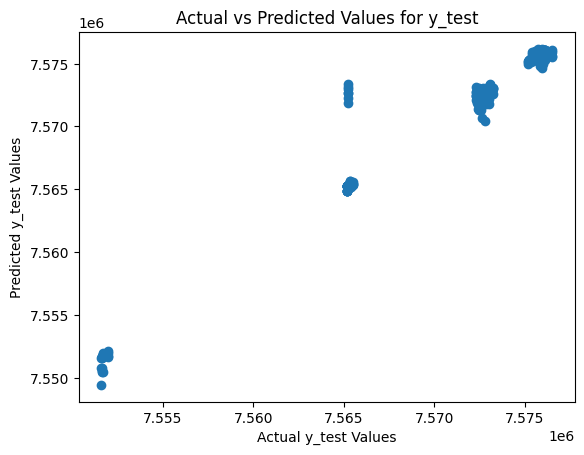

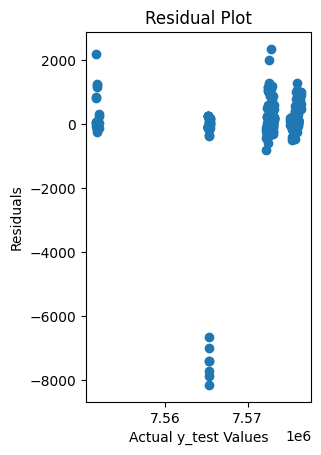

In [24]:
####### these plots would be better at the point of the tower estimates

# Plot the estimated vs actual predictions
plt.scatter(y_true, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_true - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_true, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()